# Fix position 

## Preprocessing offline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


from tqdm.notebook import tqdm

from astropy import units as u
from odisseo.units import CodeUnits
from odisseo.option_classes import SimulationParams, PlummerParams, MNParams, NFWParams, PSPParams

from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd



In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)



params_true = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, )

In [3]:
def selection_function(x, p_selecteion=0.95):
        # Implement a selection function based on the problem requirements
        x_selected = x[np.random.rand(x.shape[0]) < p_selecteion]  # Example: select 50% of the data
        return x_selected

def add_background(x, p_backgrouond=1e-3 ):
        N = 1e6
        N_background = np.random.binomial(n=N, p=p_backgrouond)
        x_background = np.random.uniform(low=np.array([6, -120, -8, -250, -2., -0.10]),
                                          high=np.array([20, 70, 2, 250, 1.0, 0.10]),
                                          size=(N_background, 6))
        x_and_background = np.concatenate((x, x_background), axis=0)
        return x_and_background

def add_noise(x, noise_std = np.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])):
        x_noise = np.random.normal(loc=x, scale=noise_std, size=x.shape)
        return x_noise

def transform_in_histogram(x, bins=[64, 32]):
        ph1_phi2, _, _ = np.histogram2d(x[:, 1], x[:, 2], bins = bins, range = [[-120., 70.], [-8, 2]] )
        R_vR, _, _ = np.histogram2d(x[:, 0], x[:, 3], bins = bins, range = [[6., 20.], [-250., 250.]] )
        vphicosphi2_vphi2, _, _ = np.histogram2d(x[:, 4], x[:, 5], bins = bins, range = [[-2., 1.], [-0.1, 0.1 ]] )
        return np.stack([ph1_phi2, R_vR, vphicosphi2_vphi2], axis=0)

def to_observation(x, p_selection=0.95, p_background=1e-3):
        """
        Convert simulation data to observation format by applying selection, adding background, noise, and transforming to histogram.
        """
        x_selected = selection_function(x, p_selection)
        x_with_background = add_background(x_selected, p_background)
        x_noise = add_noise(x_with_background)
        x_histogram = transform_in_histogram(x_noise) 
        return x_histogram

def to_inference_parameters(theta, code_units=code_units, ):
        """
        convert from simulation parameters to inference parameters
        """
        theta[0] = theta[0] # t_end is already in Gyr
        theta[1] = np.log10(theta[1]).item() # Plummer mass is already in Msun
        theta[2] = theta[2] * code_units.code_length.to(u.kpc) # Plummer a
        theta[3] = np.log10(theta[3] * code_units.code_mass.to(u.Msun)).item()  # NFW Mvir
        theta[4] = theta[4] * code_units.code_length.to(u.kpc)  # NFW r_s
        theta[5] = np.log10(theta[5] * code_units.code_mass.to(u.Msun)).item() # MN M
        theta[6] = theta[6] * code_units.code_length.to(u.kpc) # MN a
        return theta


def from_simulation_to_observation_and_inference(file, save_path, p_selection=0.95, p_background=1e-3, code_units=code_units):
    """
    Convert simulation data to observation format and inference parameters.
    """
    x, theta = np.load(file)['x'], np.load(file)['theta']
    x_observation = to_observation(x, p_selection=p_selection, p_background=p_background)
    theta_inference = to_inference_parameters(theta, code_units=code_units)
    np.savez(save_path, x=x_observation, theta=theta_inference)



#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/'
files_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz') and 'mean_std' not in f]
save_directory = '/export/data/vgiusepp/odisseo_data/data_fix_position/preprocess'

for file in tqdm(files_path):
       file_name_to_save = 'preprocess_'+os.path.basename(file)
       save_path = os.path.join(save_directory, file_name_to_save )
       if not os.path.isfile(save_path):
                from_simulation_to_observation_and_inference(
                        file=file,
                        save_path=save_path,
                        p_selection=0.95,
                        p_background=1e-3,)
                
mean_x, std_x = np.load(os.path.join(save_directory, 'mean_std.npz'))['mean_x'], np.load(os.path.join(save_directory, 'mean_std.npz'))['std_x']

  0%|          | 0/100725 [00:00<?, ?it/s]

# Normalize the histogram (needed only once)

In [4]:
# x = np.array([np.load(os.path.join(save_directory, p))['x'] for p in os.listdir(save_directory) 
#               if p.startswith('preprocess_') and p.endswith('.npz')])

# mean_x = np.mean(x)
# std_x = np.std(x)
# np.savez(os.path.join(save_directory, 'mean_std.npz'), mean=mean_x, std=std_x)
# print("Mean of x:", mean_x)
# print("Standard deviation of x:", std_x)

In [5]:
# On the fly prepocessing with pytorch
# import torch

# def selection_function(x, p_selection=0.95):
#     mask = torch.rand(x.shape[0], device=x.device) < p_selection
#     return x[mask]

# def add_background(x, p_background=1e-3):
#     N = int(1e6)
#     N_background = torch.distributions.Binomial(total_count=N, probs=p_background).sample().int()

#     low = torch.tensor([6., -120., -8., -250., -2., -0.10], device=x.device)
#     high = torch.tensor([20., 70., 2., 250., 1.0, 0.10], device=x.device)

#     # Uniform sampling in the given box
#     x_background = (high - low) * torch.rand((N_background, 6), device=x.device) + low

#     x_background = torch.distributions.Uniform(low=low, high=high).sample((N_background, )).to(x.device)
#     print(x.shape, x_background.shape)

#     return torch.cat([x, x_background], dim=0)

# def add_noise(x, noise_std=torch.tensor([0.25, 0.001, 0.15, 5., 0.1, 1e-3])):
#     noise_std = noise_std.to(x.device)
#     x_noise = torch.distributions.Normal(x, noise_std).sample((x.shape[0],))
#     return x_noise

# def transform_in_histogram(x, bins=[64, 32]):
    

#     # ph1_ph2 = hist2d(x[:, 1], x[:, 2], bins, [-120., 70.], [-8., 2.])
#     # R_vR = hist2d(x[:, 0], x[:, 3], bins, [6., 20.], [-250., 250.])
#     # vphicosphi2_vphi2 = hist2d(x[:, 4], x[:, 5], bins, [-2., 1.], [-0.1, 0.1])

#     phi1_phi2, _, _ = torch.histogramdd(torch.stack([x[:, 1], x[:, 2]], axis=1), bins=bins, range=[-120., 70., -8., 2.])
#     R_vR, _, _ = torch.histogramdd(torch.stack([x[:, 0], x[:, 3]], axis=1), bins=bins, range=[6., 20., -250., 250.])
#     vphicosphi2_vphi2, _, _ = torch.histogramdd(torch.stack([x[:, 4], x[:, 5]], axis=1), bins=bins, range=[-2., 1., -0.1, 0.1])
#     return torch.stack([phi1_phi2, R_vR, vphicosphi2_vphi2], dim=0)

# def to_observation(x, p_selection=0.95, p_background=1e-3):
#     x_selected = selection_function(x, p_selection)
#     x_with_background = add_background(x_selected, p_background)
#     x_noise = add_noise(x_with_background)
#     x_histogram = transform_in_histogram(x_noise)
#     return x_histogram


# file = '/export/data/vgiusepp/odisseo_data/data_varying_position/file_000000.npz'
# x, theta = np.load(file)['x'], np.load(file)['theta']
# x = torch.tensor(x, )
# theta = torch.tensor(theta, )
# x_observation = to_observation(x, p_selection=0.95, p_background=1e-3)
# print(theta)

## Training , validation and test set generation

In [13]:
from autocvd import autocvd
autocvd(num_gpus = 1)

# os.environ['CUDA_VISIBLE_DEVICES'] = '4'  # Set the GPU to use, if available
# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
# import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import torch
from torch import nn
import torch.nn.functional as F

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import re

from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.units import CodeUnits
from astropy import units as u



class DiskDataset(Dataset):
    def __init__(self, file_paths, file_type="npz", transform=None, code_units=code_units):
        """
        Args:
            file_paths (List[str]): List of paths to data files.
            file_type (str): Type of file to load ('npy', 'pt', or custom).
            transform (callable, optional): Optional transform to apply.
        """
        # self.file_paths = self._filter_valid_paths(file_paths)
        self.file_paths = file_paths
        self.file_type = file_type
        self.transform = transform
        # self.mean_x = torch.from_numpy(np.load(os.path.join('/export/data/vgiusepp/odisseo_data/data_fix_position/preprocess', 'mean_std.npz'))['mean_x']).float()
        # self.std_x = torch.from_numpy(np.load(os.path.join('/export/data/vgiusepp/odisseo_data/data_fix_position/preprocess', 'mean_std.npz'))['std_x']).float()

        path = self.file_paths[0]
        if self.file_type == "npz":
            x = np.load(path)['x'], #for some unknown reason this reaturns a tuple with an array inside 
            theta = np.load(path)['theta'] 
            x, theta = torch.from_numpy(x[0]).float(), torch.from_numpy(theta).float()
            # x = (x - self.mean_x) / self.std_x  # Normalize x
        self.tensors = x.unsqueeze(0), theta.unsqueeze(0)
        print(self.tensors[0].shape, self.tensors[1].shape)

    def _filter_valid_paths(self, paths):
        valid_paths = []
        for path in paths:
            try:
                data = np.load(path)
                x = data['x']  #for some unknown reason this reaturns a tuple with an array inside 
                theta = data['theta'][[0, 1, 3, 5]]
                if not np.isnan(x).any() and not np.isnan(theta).any():
                    valid_paths.append(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        return valid_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        path = self.file_paths[idx]
        x, theta = np.load(path)['x'], np.load(path)['theta'][[0, 1, 3, 5]]
        x, theta = torch.from_numpy(x).float(), torch.from_numpy(theta).float()
        # x = (x - self.mean_x) / self.std_x
        self.tensors = x, theta

        return x, theta
    
    

#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/'
data_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz') and 'mean_std' not in f]
files_path_obs = data_path[-1]
data_path = data_path[:-1]  # Exclude the last file which is the observation
#split the data into training, validation, and test sets
files_path_training = data_path[ : int(len(data_path) * 0.7)]
files_path_validation = data_path[int(len(data_path) * 0.7) : int(len(data_path) * 0.99)]
files_path_test = data_path[int(len(data_path) * 0.99) : ]


#Training
dataset_training = DiskDataset(files_path_training, file_type="npz", )
dataloader_training = DataLoader(dataset_training, batch_size=16, shuffle=True, num_workers=4)

for batch in dataloader_training:
    print('Training set shapes for x and theta:')
    # print(batch[0].shape, batch[1].shape)
    print(batch[0].shape)
    break

#Validation
dataset_validation = DiskDataset(files_path_validation, file_type="npz", )
dataloader_validation = DataLoader(dataset_validation, batch_size=16, shuffle=False, num_workers=4)
for batch in dataloader_validation:
    print('Validation set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

#Test
dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print('Test set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

# Observation
# files_path_obs = sorted(
#     f for f in Path(data_path).glob("chunk_*.npz")
#     if (m := pattern.fullmatch(f.name)) and int(m.group(1)) == 70_000)
x_obs = (torch.from_numpy(np.load(files_path_obs)['x']) - mean_x)/std_x
theta_obs = torch.from_numpy(np.load(files_path_obs)['theta'][[0, 1, 3, 5]])
print(theta_obs)



INFO:autocvd.main:Selecting 1 free GPU(s).
INFO:autocvd.main:Selected GPU(s): 8.
INFO:autocvd.main:Set environment variables CUDA_VISIBLE_DEVICES=8 and CUDA_DEVICE_ORDER=PCI_BUS_ID.


Device: cuda
torch.Size([1, 5000, 6]) torch.Size([1, 7])
Training set shapes for x and theta:
torch.Size([16, 5000, 6])
torch.Size([1, 5000, 6]) torch.Size([1, 7])
Validation set shapes for x and theta:
torch.Size([16, 5000, 6]) torch.Size([16, 4])
torch.Size([1, 5000, 6]) torch.Size([1, 7])
Test set shapes for x and theta:
torch.Size([16, 5000, 6]) torch.Size([16, 4])
tensor([2.6990e+00, 1.5146e+04, 1.3932e+07, 6.6671e+06], dtype=torch.float64)


## Embedding network

In [15]:
# import torch
# from torch import nn, einsum
# from einops import repeat, rearrange

# # helpers

# def exists(val):
#     return val is not None

# def max_value(t):
#     return torch.finfo(t.dtype).max

# def batched_index_select(values, indices, dim = 1):
#     value_dims = values.shape[(dim + 1):]
#     values_shape, indices_shape = map(lambda t: list(t.shape), (values, indices))
#     indices = indices[(..., *((None,) * len(value_dims)))]
#     indices = indices.expand(*((-1,) * len(indices_shape)), *value_dims)
#     value_expand_len = len(indices_shape) - (dim + 1)
#     values = values[(*((slice(None),) * dim), *((None,) * value_expand_len), ...)]

#     value_expand_shape = [-1] * len(values.shape)
#     expand_slice = slice(dim, (dim + value_expand_len))
#     value_expand_shape[expand_slice] = indices.shape[expand_slice]
#     values = values.expand(*value_expand_shape)

#     dim += value_expand_len
#     return values.gather(dim, indices)

# # classes

# class MultiheadPointTransformerLayer(nn.Module):
#     def __init__(
#         self,
#         *,
#         dim,
#         heads = 4,
#         dim_head = 64,
#         pos_mlp_hidden_dim = 64,
#         attn_mlp_hidden_mult = 4,
#         num_neighbors = None
#     ):
#         super().__init__()
#         self.heads = heads
#         inner_dim = dim_head * heads

#         self.num_neighbors = num_neighbors

#         self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
#         self.to_out = nn.Linear(inner_dim, dim)

#         self.pos_mlp = nn.Sequential(
#             nn.Linear(3, pos_mlp_hidden_dim),
#             nn.ReLU(),
#             nn.Linear(pos_mlp_hidden_dim, inner_dim)
#         )

#         attn_inner_dim = inner_dim * attn_mlp_hidden_mult

#         self.attn_mlp = nn.Sequential(
#             nn.Conv2d(inner_dim, attn_inner_dim, 1, groups = heads),
#             nn.ReLU(),
#             nn.Conv2d(attn_inner_dim, inner_dim, 1, groups = heads),
#         )

#     def forward(self, x, mask = None):
#         pos = x[:, :, :3]

#         n, h, num_neighbors = x.shape[1], self.heads, self.num_neighbors

#         # get queries, keys, values

#         q, k, v = self.to_qkv(x).chunk(3, dim = -1)

#         # split out heads

#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))

#         # calculate relative positional embeddings

#         rel_pos = rearrange(pos, 'b i c -> b i 1 c') - rearrange(pos, 'b j c -> b 1 j c')
#         rel_pos_emb = self.pos_mlp(rel_pos)

#         # split out heads for rel pos emb

#         rel_pos_emb = rearrange(rel_pos_emb, 'b i j (h d) -> b h i j d', h = h)

#         # use subtraction of queries to keys. i suppose this is a better inductive bias for point clouds than dot product

#         qk_rel = rearrange(q, 'b h i d -> b h i 1 d') - rearrange(k, 'b h j d -> b h 1 j d')

#         # prepare mask

#         if exists(mask):
#             mask = rearrange(mask, 'b i -> b i 1') * rearrange(mask, 'b j -> b 1 j')

#         # expand values

#         v = repeat(v, 'b h j d -> b h i j d', i = n)

#         # determine k nearest neighbors for each point, if specified

#         if exists(num_neighbors) and num_neighbors < n:
#             rel_dist = rel_pos.norm(dim = -1)

#             if exists(mask):
#                 mask_value = max_value(rel_dist)
#                 rel_dist.masked_fill_(~mask, mask_value)

#             dist, indices = rel_dist.topk(num_neighbors, largest = False)

#             indices_with_heads = repeat(indices, 'b i j -> b h i j', h = h)

#             v = batched_index_select(v, indices_with_heads, dim = 3)
#             qk_rel = batched_index_select(qk_rel, indices_with_heads, dim = 3)
#             rel_pos_emb = batched_index_select(rel_pos_emb, indices_with_heads, dim = 3)

#             if exists(mask):
#                 mask = batched_index_select(mask, indices, dim = 2)

#         # add relative positional embeddings to value

#         v = v + rel_pos_emb

#         # use attention mlp, making sure to add relative positional embedding first

#         attn_mlp_input = qk_rel + rel_pos_emb
#         attn_mlp_input = rearrange(attn_mlp_input, 'b h i j d -> b (h d) i j')

#         sim = self.attn_mlp(attn_mlp_input)

#         # masking

#         if exists(mask):
#             mask_value = -max_value(sim)
#             mask = rearrange(mask, 'b i j -> b 1 i j')
#             sim.masked_fill_(~mask, mask_value)

#         # attention

#         attn = sim.softmax(dim = -2)

#         # aggregate

#         v = rearrange(v, 'b h i j d -> b i j (h d)')
#         agg = einsum('b d i j, b i j d -> b i d', attn, v)

#         # combine heads

#         return self.to_out(agg)
    
# embedding_net = MultiheadPointTransformerLayer(
#     dim=6,  # Input dimension of the data)
#     heads=1,
# )


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Particle3DCNN(nn.Module):
    def __init__(self, 
                 grid_size=32,
                 input_channels=6,
                 output_dim=10,  # For your 10 parameters
                 feature_channels=[32, 64, 128, ],
                 dropout_rate=0.1):
        """
        3D CNN for particle data
        
        Args:
            grid_size: Size of the 3D voxel grid (grid_size^3)
            input_channels: Number of features per particle (6 in your case)
            output_dim: Number of output parameters for SBI
            feature_channels: List of channel sizes for each conv layer
            dropout_rate: Dropout probability
        """
        super(Particle3DCNN, self).__init__()
        
        self.grid_size = grid_size
        self.input_channels = input_channels
        self.output_dim = output_dim
        
        # 3D Convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels
        
        for out_channels in feature_channels:
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm3d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm3d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.MaxPool3d(kernel_size=2, stride=2)
                )
            )
            in_channels = out_channels
        
        # Calculate the flattened size after convolutions
        self.flattened_size = self._get_flattened_size()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_dim)
        )
        
    def _get_flattened_size(self):
        """Calculate the size after convolutions"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, self.grid_size, self.grid_size, self.grid_size)
            x = dummy_input
            for conv_layer in self.conv_layers:
                x = conv_layer(x)
            return x.numel()
    
    def voxelize_particles(self, particles):
        """
        Convert particle data to 3D voxel grid
        
        Args:
            particles: (batch, N_particles, 6) tensor
                       Assumes first 3 dims are spatial coordinates
        
        Returns:
            voxel_grid: (batch, 6, grid_size, grid_size, grid_size) tensor
        """
        batch_size, n_particles, n_features = particles.shape
        device = particles.device
        
        # Initialize voxel grid
        voxel_grid = torch.zeros(batch_size, n_features, self.grid_size, self.grid_size, self.grid_size, device=device)
        
        # Normalize spatial coordinates to [0, grid_size-1]
        # Assuming first 3 dimensions are spatial (x, y, z)
        spatial_coords = particles[:, :, :3]  # (batch, N_particles, 3)
        
        # Normalize coordinates to grid range
        for dim in range(3):
            coord_min = spatial_coords[:, :, dim].min(dim=1, keepdim=True)[0]
            coord_max = spatial_coords[:, :, dim].max(dim=1, keepdim=True)[0]
            coord_range = coord_max - coord_min
            coord_range = torch.clamp(coord_range, min=1e-6)  # Avoid division by zero
            
            spatial_coords[:, :, dim] = (spatial_coords[:, :, dim] - coord_min) / coord_range
            spatial_coords[:, :, dim] = spatial_coords[:, :, dim] * (self.grid_size - 1)
        
        # Convert to integer indices
        indices = spatial_coords.long()
        indices = torch.clamp(indices, 0, self.grid_size - 1)
        
        # Fill voxel grid
        for b in range(batch_size):
            for p in range(n_particles):
                i, j, k = indices[b, p, 0], indices[b, p, 1], indices[b, p, 2]
                # Add all features to this voxel
                for f in range(n_features):
                    voxel_grid[b, f, i, j, k] += particles[b, p, f]
        
        return voxel_grid
    
    def forward(self, particles):
        """
        Forward pass
        
        Args:
            particles: (batch, N_particles, 6) tensor
        
        Returns:
            output: (batch, output_dim) tensor
        """
        # Convert particles to voxel grid
        voxel_grid = self.voxelize_particles(particles)
        
        # Apply 3D convolutions
        x = voxel_grid
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Flatten and apply fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        
        return x


# Alternative: More sophisticated voxelization with density estimation
class DensityParticle3DCNN(nn.Module):
    def __init__(self, 
                 grid_size=32,
                 input_channels=6,
                 output_dim=10,
                 feature_channels=[32, 64, 128, 256],
                 dropout_rate=0.1,
                 sigma=1.0):  # Gaussian kernel width
        super(DensityParticle3DCNN, self).__init__()
        
        self.grid_size = grid_size
        self.input_channels = input_channels
        self.output_dim = output_dim
        self.sigma = sigma
        
        # 3D Convolutional layers with residual connections
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels
        
        for i, out_channels in enumerate(feature_channels):
            self.conv_layers.append(
                ResidualBlock3D(in_channels, out_channels, downsample=(i > 0))
            )
            in_channels = out_channels
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_channels[-1], 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, output_dim)
        )
    
    def gaussian_voxelize(self, particles):
        """
        Voxelize particles using Gaussian density estimation
        """
        batch_size, n_particles, n_features = particles.shape
        device = particles.device
        
        # Create coordinate grids
        x = torch.linspace(0, 1, self.grid_size, device=device)
        y = torch.linspace(0, 1, self.grid_size, device=device)
        z = torch.linspace(0, 1, self.grid_size, device=device)
        
        grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing='ij')
        grid_coords = torch.stack([grid_x, grid_y, grid_z], dim=-1)  # (grid_size, grid_size, grid_size, 3)
        
        voxel_grid = torch.zeros(batch_size, n_features, self.grid_size, self.grid_size, self.grid_size, device=device)
        
        # Normalize particle coordinates
        spatial_coords = particles[:, :, :3]
        for dim in range(3):
            coord_min = spatial_coords[:, :, dim].min(dim=1, keepdim=True)[0]
            coord_max = spatial_coords[:, :, dim].max(dim=1, keepdim=True)[0]
            coord_range = coord_max - coord_min
            coord_range = torch.clamp(coord_range, min=1e-6)
            spatial_coords[:, :, dim] = (spatial_coords[:, :, dim] - coord_min) / coord_range
        
        # For each batch
        for b in range(batch_size):
            for p in range(n_particles):
                particle_pos = spatial_coords[b, p, :3]  # (3,)
                
                # Calculate Gaussian weights
                distances = torch.sum((grid_coords - particle_pos)**2, dim=-1)  # (grid_size, grid_size, grid_size)
                weights = torch.exp(-distances / (2 * self.sigma**2))
                
                # Add weighted features to voxel grid
                for f in range(n_features):
                    voxel_grid[b, f] += weights * particles[b, p, f]
        
        return voxel_grid
    
    def forward(self, particles):
        # Voxelize with Gaussian density estimation
        voxel_grid = self.gaussian_voxelize(particles)
        
        # Apply 3D convolutions
        x = voxel_grid
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc_layers(x)
        
        return x


class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock3D, self).__init__()
        
        stride = 2 if downsample else 1
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(residual)
        out = F.relu(out)
        
        return out


# For your specific use case
def create_embedding_network_3d(output_dim=10, grid_size=32):
    """
    Create a 3D CNN embedding network for your stellar stream data
    
    Args:
        output_dim: Number of parameters to infer (10 for varying position case)
        grid_size: Size of the 3D voxel grid
    
    Returns:
        3D CNN model
    """
    return DensityParticle3DCNN(
        grid_size=grid_size,
        input_channels=6,  # Your 6 features per particle
        output_dim=output_dim,
        feature_channels=[32, 64, 128, 256],
        dropout_rate=0.1,
        sigma=0.05  # Gaussian kernel width for voxelization
    )

# Usage in your notebook:
embedding_net = create_embedding_network_3d(output_dim=10, grid_size=32)

# Test the network
if __name__ == "__main__":
    # Test with dummy data
    batch_size = 16
    n_particles = 5000
    n_features = 6
    
    dummy_particles = torch.randn(batch_size, n_particles, n_features)
    
    model = create_embedding_network_3d(output_dim=10)
    output = model(dummy_particles)
    
    print(f"Input shape: {dummy_particles.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Input shape: torch.Size([16, 5000, 6])
Output shape: torch.Size([16, 10])
Number of parameters: 3829482


## Inference pipeline

In [16]:
# ltu-ili 
loader = ili.dataloaders.TorchLoader(
    train_loader=dataloader_training,
    val_loader=dataloader_validation,
)

trainer = ili.inference.InferenceRunner.load(
  backend = 'lampe',          # Choose a backend and inference engine (here, Neural Posterior Estimation)
  engine='NPE',               
  # define a prior
  prior = ili.utils.Uniform(low=[0.5, # t_end in Gyr
                                np.log10(10**3.0).item(), # Plummer mass
                                # params_true.Plummer_params.a*(1/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(1/4) * code_units.code_mass.to(u.Msun)).item(),
                                # params_true.NFW_params.r_s*(1/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(1/4) * code_units.code_mass.to(u.Msun)).item(), ],
                                # params_true.MN_params.a*(1/4) * code_units.code_length.to(u.kpc), ], 
                            high=[5, # t_end in Gyr
                                np.log10(10**4.5).item(), #Plummer mass
                                # params_true.Plummer_params.a*(8/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                # params_true.NFW_params.r_s*(8/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(8/4) * code_units.code_mass.to(u.Msun)).item(), ],
                                # params_true.MN_params.a*(8/4) * code_units.code_length.to(u.kpc),], 
                            device=device),

  # Define a neural network architecture (here, MAF)
  nets = [ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=False,
                                   theta_normalize=True,
                                   hidden_features=32,
                                   num_transforms=5),  ],
                                
  device = device,
  train_args = {'stop_after_epochs': 5, 'max_epochs': 200, }
)

posterior, summary = trainer(loader)                  # Run training to map data -> parameters

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
0 epochs [2:24:57, ? epochs/s]


KeyboardInterrupt: 

INFO:root:Sampling models with [1464, 1572, 1789, 1757, 1797, 1622] samples each.
Drawing 1464 posterior samples: 1976it [00:00, 34404.52it/s]            
Drawing 1572 posterior samples: 1997it [00:00, 18169.65it/s]            
Drawing 1789 posterior samples: 1990it [00:00, 10193.14it/s]            
Drawing 1757 posterior samples: 1967it [00:00, 6731.97it/s]                         
Drawing 1797 posterior samples: 1931it [00:00, 22581.21it/s]            
Drawing 1622 posterior samples: 1726it [00:00, 9569.57it/s]             
100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


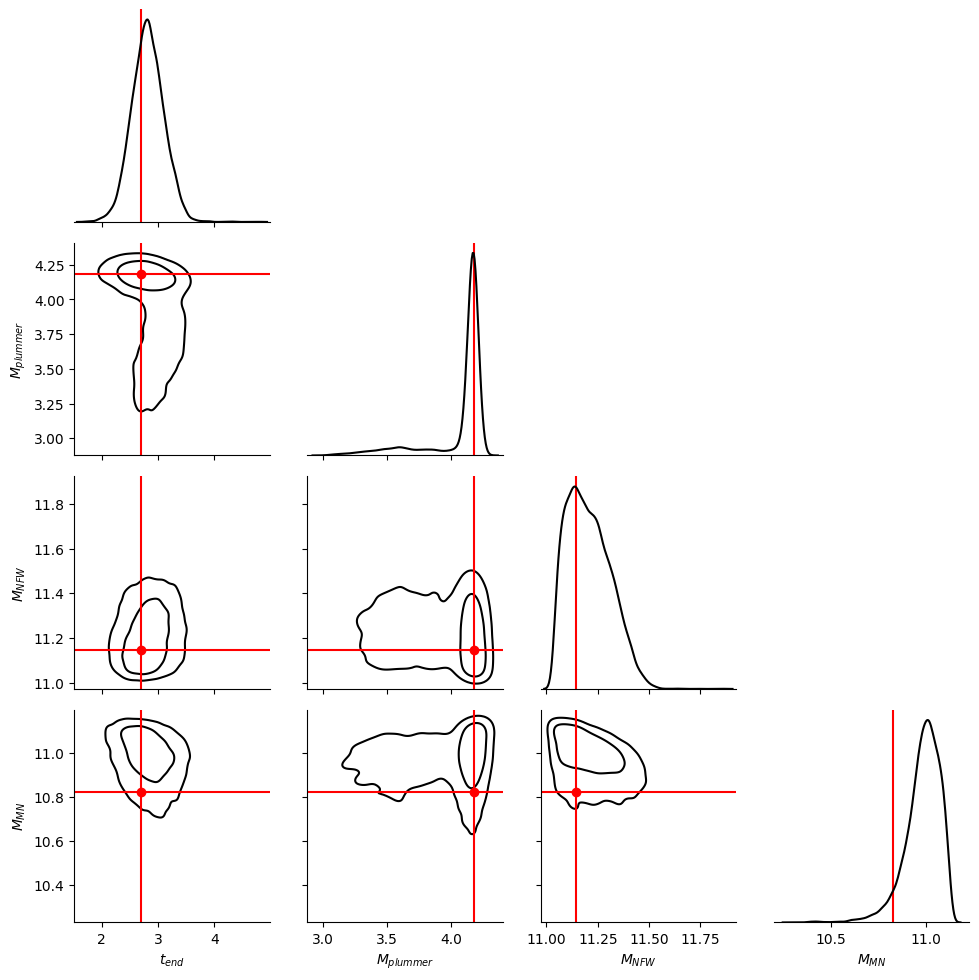

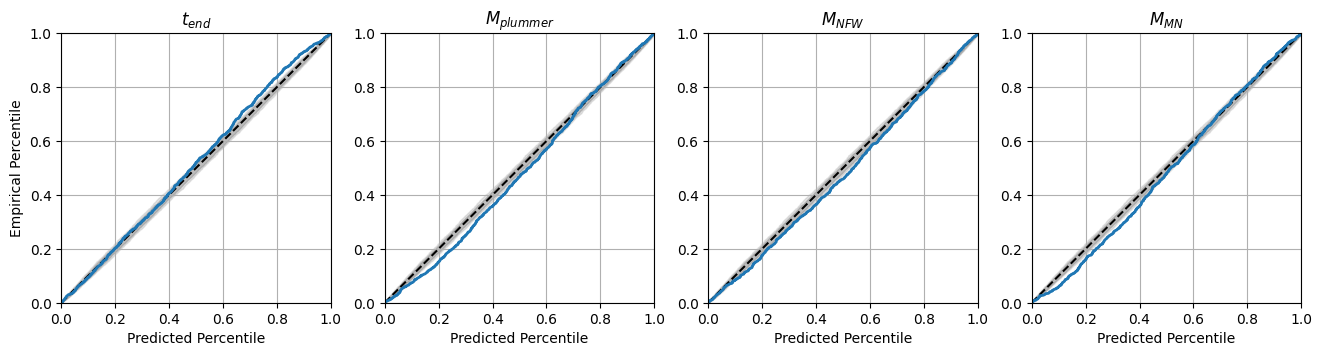

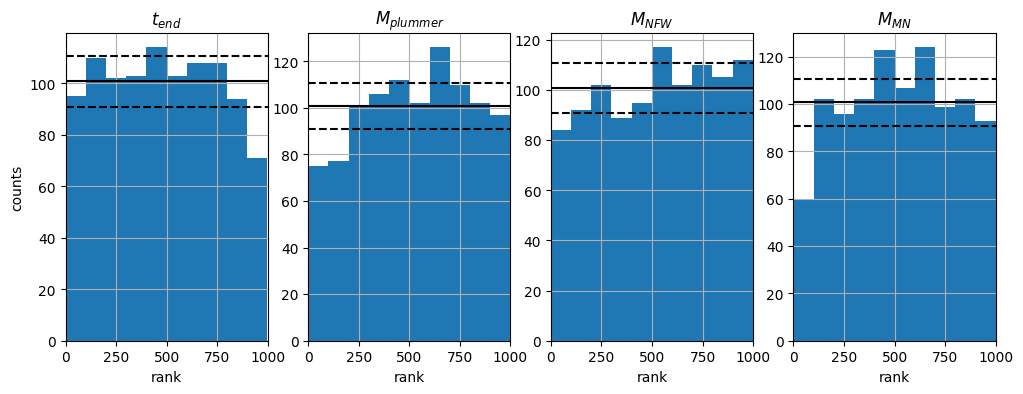

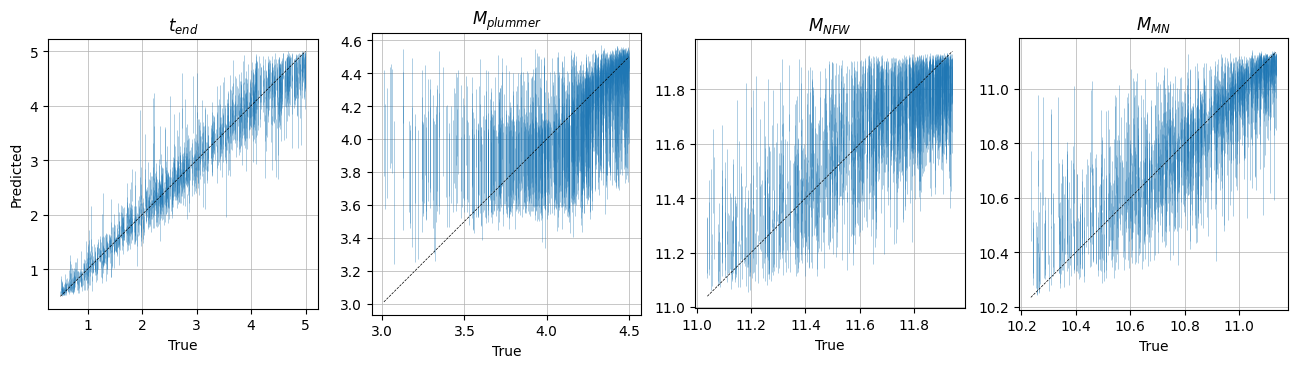

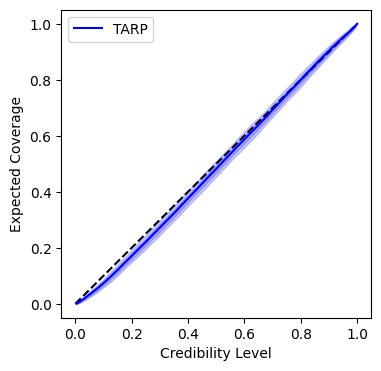

In [11]:
# REMBEMBDER SBI <= 0.22

# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels=['$t_{end}$', 
            '$M_{plummer}$',
            #  '$a_{plummer}$', 
                '$M_{NFW}$', 
            #  '$r_{NFW}$',
                '$M_{MN}$', ])

fig = metric(
    posterior=posterior,
    x_obs = x_obs.unsqueeze(0), theta_fid=theta_obs
)

fig.savefig("./fix_position_inference/posterior_plot.pdf", bbox_inches='tight', format='pdf')



def dataloader_to_tensors(dataloader):
    xs, thetas = [], []
    for x_batch, theta_batch in dataloader:
        xs.append(x_batch)
        thetas.append(theta_batch)
    x_tensor = torch.cat(xs, dim=0)
    theta_tensor = torch.cat(thetas, dim=0)
    return x_tensor, theta_tensor

x, theta = dataloader_to_tensors(dataloader_test)

               
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['$t_{end}$', 
            '$M_{plummer}$', 
            # '$a_{plummer}$', 
            '$M_{NFW}$', 
            # '$r_{NFW}$', 
            '$M_{MN}$', 
            # '$a_{MN}$'
            ],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None)


fig = metric(
    posterior=posterior,
    x=x.unsqueeze(1), theta=theta
)

plot_list = ["coverage", "histogram", "predictions", "tarp"]
for i, f in enumerate(fig):
    name= plot_list[i]
    f.savefig(f"./fix_position_inference/posterior_coverage_{name}.pdf", bbox_inches='tight', format='pdf')
               


# Varying position

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

from astropy import units as u
from odisseo.units import CodeUnits
from odisseo.option_classes import SimulationParams, PlummerParams, MNParams, NFWParams, PSPParams

from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

code_length = 10.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)



params_true = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


def selection_function(x, p_selecteion=0.95):
        # Implement a selection function based on the problem requirements
        x_selected = x[np.random.rand(x.shape[0]) < p_selecteion]  # Example: select 50% of the data
        return x_selected

def add_background(x, p_backgrouond=1e-3 ):
        N = 1e6
        N_background = np.random.binomial(n=N, p=p_backgrouond)
        x_background = np.random.uniform(low=np.array([6, -120, -8, -250, -2., -0.10]),
                                          high=np.array([20, 70, 2, 250, 1.0, 0.10]),
                                          size=(N_background, 6))
        x_and_background = np.concatenate((x, x_background), axis=0)
        return x_and_background

def add_noise(x, noise_std = np.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])):
        x_noise = np.random.normal(loc=x, scale=noise_std, size=x.shape)
        return x_noise

def transform_in_histogram(x, bins=[64, 32]):
        ph1_phi2, _, _ = np.histogram2d(x[:, 1], x[:, 2], bins = bins, range = [[-120., 70.], [-8, 2]] )
        R_vR, _, _ = np.histogram2d(x[:, 0], x[:, 3], bins = bins, range = [[6., 20.], [-250., 250.]] )
        vphicosphi2_vphi2, _, _ = np.histogram2d(x[:, 4], x[:, 5], bins = bins, range = [[-2., 1.], [-0.1, 0.1 ]] )
        return np.stack([ph1_phi2, R_vR, vphicosphi2_vphi2], axis=0)

def to_observation(x, p_selection=0.95, p_background=1e-3):
        """
        Convert simulation data to observation format by applying selection, adding background, noise, and transforming to histogram.
        """
        x_selected = selection_function(x, p_selection)
        x_with_background = add_background(x_selected, p_background)
        x_noise = add_noise(x_with_background)
        x_histogram = transform_in_histogram(x_noise) 
        return x_histogram

def to_inference_parameters(theta, code_units=code_units, ):
        """
        convert from simulation parameters to inference parameters. The position do not need to be converted to kpc since they are already in kpc and km/s
        """
        theta[0] = theta[0] # t_end is already in Gyr
        theta[1] = np.log10(theta[1]).item() # Plummer mass is already in Msun
        # theta[2] = theta[2] * code_units.code_length.to(u.kpc) # Plummer a
        theta[3] = np.log10(theta[3] * code_units.code_mass.to(u.Msun)).item()  # NFW Mvir
        # theta[4] = theta[4] * code_units.code_length.to(u.kpc)  # NFW r_s
        theta[5] = np.log10(theta[5] * code_units.code_mass.to(u.Msun)).item() # MN M
        # theta[6] = theta[6] * code_units.code_length.to(u.kpc) # MN a
        return theta


def from_simulation_to_observation_and_inference(file, save_path, p_selection=0.95, p_background=1e-3, code_units=code_units):
    """
    Convert simulation data to observation format and inference parameters.
    """
    x, theta = np.load(file)['x'], np.load(file)['theta']
    x_observation = to_observation(x, p_selection=p_selection, p_background=p_background)
    theta_inference = to_inference_parameters(theta, code_units=code_units)
    np.savez(save_path, x=x_observation, theta=theta_inference)



#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_varying_position/'
files_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz') and 'mean_std' not in f]
save_directory = '/export/data/vgiusepp/odisseo_data/data_varying_position/preprocess'

for file in tqdm(files_path):
       file_name_to_save = 'preprocess_'+os.path.basename(file)
       save_path = os.path.join(save_directory, file_name_to_save )
       if not os.path.isfile(save_path):
                from_simulation_to_observation_and_inference(
                        file=file,
                        save_path=save_path,
                        p_selection=0.95,
                        p_background=1e-3,)
                
mean_x, std_x = np.load(os.path.join(save_directory, 'mean_std.npz'))['mean_x'], np.load(os.path.join(save_directory, 'mean_std.npz'))['std_x']

100%|██████████| 100000/100000 [00:13<00:00, 7634.61it/s]


# Normalize the dataset needed only once

In [2]:
# x = np.array([np.load(os.path.join(save_directory, p))['x'] for p in os.listdir(save_directory) 
#               if p.startswith('preprocess_') and p.endswith('.npz')])

# mean_x = np.mean(x)
# std_x = np.std(x)
# np.savez(os.path.join(save_directory, 'mean_std.npz'), mean=mean_x, std=std_x)
# print("Mean of x:", mean_x)
# print("Standard deviation of x:", std_x)

## Training, validation and test set generation

In [3]:
# from autocvd import autocvd
# autocvd(num_gpus = 1)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Set the GPU to

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
# import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import torch
from torch import nn
import torch.nn.functional as F

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import re

from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.units import CodeUnits
from astropy import units as u



class DiskDataset(Dataset):
    def __init__(self, file_paths, file_type="npz", transform=None, code_units=code_units):
        """
        Args:
            file_paths (List[str]): List of paths to data files.
            file_type (str): Type of file to load ('npy', 'pt', or custom).
            transform (callable, optional): Optional transform to apply.
        """
        # self.file_paths = self._filter_valid_paths(file_paths)
        self.file_paths = file_paths
        self.file_type = file_type
        self.transform = transform
        self.mean_x = torch.from_numpy(np.load(os.path.join('/export/data/vgiusepp/odisseo_data/data_varying_position/preprocess', 'mean_std.npz'))['mean_x']).float()
        self.std_x = torch.from_numpy(np.load(os.path.join('/export/data/vgiusepp/odisseo_data/data_varying_position/preprocess', 'mean_std.npz'))['std_x']).float()

        path = self.file_paths[0]
        if self.file_type == "npz":
            x = np.load(path)['x'], #for some unknown reason this reaturns a tuple with an array inside 
            theta = np.load(path)['theta'][[0, 1, 3, 5, 7, 8, 9, 10, 11, 12] ]
            x, theta = torch.from_numpy(x[0]).float(), torch.from_numpy(theta).float()
            x = (x - self.mean_x) / self.std_x
        self.tensors = x.unsqueeze(0), theta.unsqueeze(0)
        print(self.tensors[0].shape, self.tensors[1].shape)

    def _filter_valid_paths(self, paths):
        valid_paths = []
        for path in paths:
            try:
                data = np.load(path)
                x = data['x']  #for some unknown reason this reaturns a tuple with an array inside 
                theta = data['theta']
                if not np.isnan(x).any() and not np.isnan(theta).any():
                    valid_paths.append(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        return valid_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        path = self.file_paths[idx]
        x, theta = np.load(path)['x'], np.load(path)['theta'][[0, 1, 3, 5, 7, 8, 9, 10, 11, 12]] # Select only the relevant parameters
        x, theta = torch.from_numpy(x).float(), torch.from_numpy(theta).float()
        x = (x - self.mean_x) / self.std_x
        self.tensors = x, theta

        return x, theta
    
    

#load data paths
data_path = '/export/data/vgiusepp/odisseo_data/data_varying_position/preprocess'
data_path = [os.path.join(data_path, f) for f in sorted(os.listdir(data_path)) if f.endswith('.npz') and 'mean_std' not in f]
files_path_obs = data_path[-1]
data_path = data_path[:-1]  # Exclude the last file which is the observation
#split the data into training, validation, and test sets
files_path_training = data_path[ : int(len(data_path) * 0.7)]
files_path_validation = data_path[int(len(data_path) * 0.7) : int(len(data_path) * 0.9)]
files_path_test = data_path[int(len(data_path) * 0.9) : ]


#Training
dataset_training = DiskDataset(files_path_training, file_type="npz", )
dataloader_training = DataLoader(dataset_training, batch_size=1024, shuffle=True, num_workers=4)

for batch in dataloader_training:
    print('Training set shapes for x and theta:')
    # print(batch[0].shape, batch[1].shape)
    print(batch[0].shape)
    break

#Validation
dataset_validation = DiskDataset(files_path_validation, file_type="npz", )
dataloader_validation = DataLoader(dataset_validation, batch_size=1024, shuffle=False, num_workers=4)
for batch in dataloader_validation:
    print('Validation set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

#Test
dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print('Test set shapes for x and theta:')
    print(batch[0].shape, batch[1].shape)
    break

# Observation
# files_path_obs = sorted(
#     f for f in Path(data_path).glob("chunk_*.npz")
#     if (m := pattern.fullmatch(f.name)) and int(m.group(1)) == 70_000)
x_obs = torch.from_numpy(np.load(files_path_obs)['x'])
theta_obs = torch.from_numpy(np.load(files_path_obs)['theta'])[[0, 1, 3, 5, 7, 8, 9, 10, 11, 12]]
print(theta_obs)



2025-06-29 16:39:30.152318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751207970.173049 3186365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751207970.179489 3186365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda
torch.Size([1, 3, 64, 32]) torch.Size([1, 10])
Training set shapes for x and theta:
torch.Size([1024, 3, 64, 32])
torch.Size([1, 3, 64, 32]) torch.Size([1, 10])
Validation set shapes for x and theta:
torch.Size([1024, 3, 64, 32]) torch.Size([1024, 10])
torch.Size([1, 3, 64, 32]) torch.Size([1, 10])
Test set shapes for x and theta:
torch.Size([512, 3, 64, 32]) torch.Size([512, 10])
tensor([ 2.0665e+00,  4.4729e+00,  1.1717e+01,  1.0933e+01,  1.1940e+01,
         1.0872e-01,  7.8536e+00,  1.0022e+02, -2.3701e+02, -1.1257e+02],
       dtype=torch.float64)


## Embedding

In [4]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down = Down(64, 128)
        self.up = Up(128, 64, False)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.down(x0)
        up = self.up(x1, x0)
        f = self.outc(up)
        return f


class LinearCompression(nn.Module):
    def __init__(self, out_channels=32):
        super(LinearCompression, self).__init__()
        self.sequential = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(out_channels),
        )

    def forward(self, x):
        return self.sequential(x)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

class embedding_network(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(embedding_network, self).__init__()
        self.unet = Unet(in_channels, out_channels)
        self.linear_compression = LinearCompression(out_channels=out_channels)
        self.flatten = nn.Flatten(1)
    
    def forward(self, x):
        x = self.unet(x)
        x = self.flatten(x)
        x = self.linear_compression(x)
        return x



embedding_net = embedding_network(out_channels=12)

## Inference pipeline

In [5]:
# ltu-ili 
loader = ili.dataloaders.TorchLoader(
    train_loader=dataloader_training,
    val_loader=dataloader_validation,
)

trainer = ili.inference.InferenceRunner.load(
  backend = 'lampe',          # Choose a backend and inference engine (here, Neural Posterior Estimation)
  engine='NPE',               
  # define a prior
  prior = ili.utils.Uniform(low=[0.5, # t_end in Gyr
                                np.log10(10**3.0).item(), # Plummer mass
                                # params_true.Plummer_params.a*(1/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(1/4) * code_units.code_mass.to(u.Msun)).item(),
                                # params_true.NFW_params.r_s*(1/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(1/4) * code_units.code_mass.to(u.Msun)).item(), 
                                # params_true.MN_params.a*(1/4) * code_units.code_length.to(u.kpc), 
                                10.0, #x
                                0.1, #y
                                6.0, #z
                                90.0, #vx
                                -280.0, #vy
                                -120.0], 
                            high=[5, # t_end in Gyr
                                np.log10(10**4.5).item(), #Plummer mass
                                # params_true.Plummer_params.a*(8/4) * code_units.code_length.to(u.kpc),
                                np.log10(params_true.NFW_params.Mvir*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                # params_true.NFW_params.r_s*(8/4) * code_units.code_length.to(u.kpc), 
                                np.log10(params_true.MN_params.M*(8/4) * code_units.code_mass.to(u.Msun)).item(), 
                                # params_true.MN_params.a*(8/4) * code_units.code_length.to(u.kpc),
                                14.0, #x
                                2.5,  #y
                                8.0,  #z
                                115.0, #vx
                                -230.0, #vy
                                -80.0], 
                            device=device),

  # Define a neural network architecture (here, MAF)
  nets = [ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=False,
                                   theta_normalize=True,
                                   hidden_features=32,
                                   num_transforms=10),
         ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=False,
                                   theta_normalize=True,
                                   hidden_features=64, 
                                   num_transforms=10)],
  device = device,
  train_args = {'stop_after_epochs': 5, 'max_epochs': 200}
)

posterior, summary = trainer(loader)                  # Run training to map data -> parameters

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
21 epochs [13:28, 38.48s/ epochs, loss=9.84, loss_val=12.9]
INFO:root:Training model 2 / 2.
20 epochs [13:53, 41.66s/ epochs, loss=8.51, loss_val=13.1]
INFO:root:It took 1653.7914264202118 seconds to train models.


In [ ]:
# REMBEMBDER SBI <= 0.22


# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=10_002, sample_method='direct', 
    labels=['$t_{end}$', '$M_{plummer}$', '$M_{NFW}$', '$M_{MN}$', 
            'x', 'y', 'z', 'vx', 'vy', 'vz'],)

fig = metric(
    posterior=posterior,
    x_obs = x_obs.unsqueeze(0), theta_fid=theta_obs
)


fig.savefig("./varying_position_inference/posterior_plot.pdf", bbox_inches='tight', format='pdf')



def dataloader_to_tensors(dataloader):
    xs, thetas = [], []
    for x_batch, theta_batch in dataloader:
        xs.append(x_batch)
        thetas.append(theta_batch)
    x_tensor = torch.cat(xs, dim=0)
    theta_tensor = torch.cat(thetas, dim=0)
    return x_tensor, theta_tensor

x, theta = dataloader_to_tensors(dataloader_test)

               
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['$t_{end}$', '$M_{plummer}$', '$M_{NFW}$', '$M_{MN}$',
            'x', 'y', 'z', 'vx', 'vy', 'vz'],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None)


fig = metric(
    posterior=posterior,
    x=x.unsqueeze(1), theta=theta
)

plot_list = ["coverage", "histogram", "predictions", "tarp"]
for i, f in enumerate(fig):
    name= plot_list[i]
    f.savefig(f"./varying_position_inference/posterior_coverage_{name}.pdf", bbox_inches='tight', format='pdf')
               


INFO:root:Sampling models with [5082, 4920] samples each.
Drawing 5082 posterior samples:   0%|          | 0/5082 [00:00<?, ?it/s]

  3%|▎         | 295/10000 [02:20<1:17:22,  2.09it/s]